<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ML%20ECG%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

2025 march - Gensim library has been updated. So, we neen reconfigure dependencies.

see more informations
https://github.com/Sinaptik-AI/pandas-ai/issues/1251

In [ ]:
!pip install --upgrade gensim --quiet
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 903.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

In [2]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='hist')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('%.1f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Таблица анализа данных, коэффициент корреляции')
    plt.show()

In [3]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

# Загрузка, очистка и визуализация данных

Пример - медицина - дата сет кардиология:
выгружено и предобработано MIMIC-IV-ECG/ Diagnostic Electrocardiogram Matched Subset v1.0

Столбец **Healthy_Status**: 0 = пациент, 1 - условно здоровый.

https://physionet.org/content/mimic-iv-ecg/1.0/

Декодированы метки времени, добавлен признак Healthy_Status

Полезная ссылка на понимание ЭКГ: https://ecgwaves.com/topic/ecg-normal-p-wave-qrs-complex-st-segment-t-wave-j-point/

Полный датасет ECG_array_arrow_data.csv:

https://drive.google.com/file/d/1-Z2Yvcl7J8ZhdSp-MEqTHfzdrhbSdcdB/view?usp=share_link


In [4]:
# загружаем полный датасет
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)
raw_table_data.head(10)

subject_id  Count_subj  study_id  cart_id  Healthy_Status eeg_time   \
0    19557662          27  40000017  6848296               0   8:44 AM   
1    18477137          93  40000029  6848296               0   9:54 AM   
2    16598616           3  40000035  6376932               1   9:07 AM   
3    16368287           7  40000079  6214760               1   5:14 PM   
4    18370366           2  40000084  6632385               0   1:52 PM   
5    15606157          55  40000089  6632385               0   2:29 PM   
6    12576058          43  40000115  6852956               1  12:54 PM   
7    14691089           1  40000143  6551957               0  10:01 AM   
8    14144725           7  40000144  6924910               0   7:24 AM   
9    16089780           2  40000152  6919786               0  12:35 PM   

    eeg_date                    report_0  \
0  27.06.2015               Sinus rhythm   
1  27.06.2015               Sinus rhythm   
2  28.06.2015          Sinus tachycardia   
3  15.07.2015               Sinus rhythm   
4  27.09.2015               Sinus rhythm   
5  29.10.2013               Sinus rhythm   
6  23.03.2016               Sinus rhythm   
7  10.12.2016               Sinus rhythm   
8  11.12.2011  Sinus rhythm with PAC(s).   
9  13.12.2011               Sinus rhythm   

                                            report_1  \
0                  Possible right atrial abnormality   
1                  Possible right atrial abnormality   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7                 rSr'(V1) - probable normal variant   
8                                                NaN   
9  Extensive T wave changes may be due to myocard...   

                               report_2  ...                    filtering  \
0                                   NaN  ...  60 Hz notch Baseline filter   
1                                   NaN  ...  60 Hz notch Baseline filter   
2            Normal ECG except for rate  ...  60 Hz notch Baseline filter   
3                            Normal ECG  ...  60 Hz notch Baseline filter   
4                                   NaN  ...              <not specified>   
5                                   NaN  ...              <not specified>   
6                            Normal ECG  ...  60 Hz notch Baseline filter   
7  Low QRS voltages in precordial leads  ...  60 Hz notch Baseline filter   
8                        Borderline ECG  ...  60 Hz notch Baseline filter   
9                                   NaN  ...  60 Hz notch Baseline filter   

  rr_interval p_onset  p_end qrs_onset qrs_end t_end p_axis qrs_axis t_axis  
0         659      40    128       170     258   518     81       77     79  
1         722      40    124       162     246   504     77       75     70  
2         600      40    130       162     244   474     79       72     77  
3         659      40    146       180     254   538     79       66     69  
4         659     368  29999       504     590   868     84       80     77  
5         822     365  29999       499     592   852     26       46     30  
6         952      40    146       198     282   598     24       80     20  
7         923      40    140       188     278   594     26       86     13  
8         952      40    180       196     294   610     59      -17      3  
9        1000      40    156       178     274   584      8      -11     19  

[10 rows x 36 columns]

In [5]:
# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    #words = sentence.split()
    words = sentence.lower().split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

In [6]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

In [7]:
print(full_df_filtered['report'][1])

Sinus rhythm Possible right atrial abnormality Borderline ECG


In [8]:
print(full_df_filtered['report'][1].lower().split())

['sinus', 'rhythm', 'possible', 'right', 'atrial', 'abnormality', 'borderline', 'ecg']


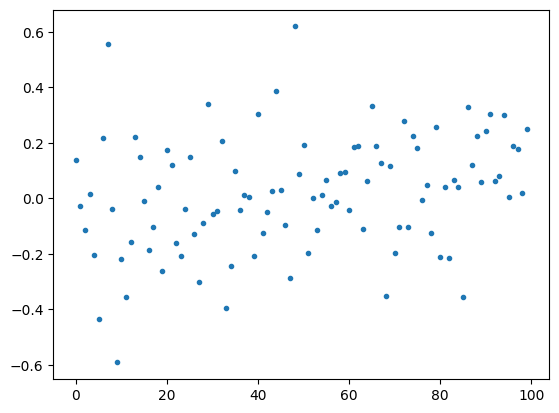

In [13]:
word_vec_example = get_sentence_embedding(full_df_filtered['report'][1])
plt.plot(word_vec_example,'.')

In [14]:
len(word_vec_example)

100

In [9]:
# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)


# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

subject_id  Count_subj  study_id  cart_id  eeg_time    eeg_date    report  \
0    19557662          27  40000017  6848296   8:44 AM  27.06.2015  0.014857   
1    18477137          93  40000029  6848296   9:54 AM  27.06.2015  0.014857   
2    16598616           3  40000035  6376932   9:07 AM  28.06.2015  0.039707   
3    16368287           7  40000079  6214760   5:14 PM  15.07.2015  0.022280   
6    12576058          43  40000115  6852956  12:54 PM  23.03.2016  0.022280   

   rr_interval  p_onset  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  \
0          659       40    128        170      258    518      81        77   
1          722       40    124        162      246    504      77        75   
2          600       40    130        162      244    474      79        72   
3          659       40    146        180      254    538      79        66   
6          952       40    146        198      282    598      24        80   

   t_axis  Healthy_Status  
0      79               0  
1      70               0  
2      77               1  
3      69               1  
6      20               1

In [10]:
# make new dataset from old columns
table_data = full_df_filtered[['report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data.head()

report  rr_interval  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  \
0  0.014857          659    128        170      258    518      81        77   
1  0.014857          722    124        162      246    504      77        75   
2  0.039707          600    130        162      244    474      79        72   
3  0.022280          659    146        180      254    538      79        66   
6  0.022280          952    146        198      282    598      24        80   

   t_axis  Healthy_Status  
0      79               0  
1      70               0  
2      77               1  
3      69               1  
6      20               1

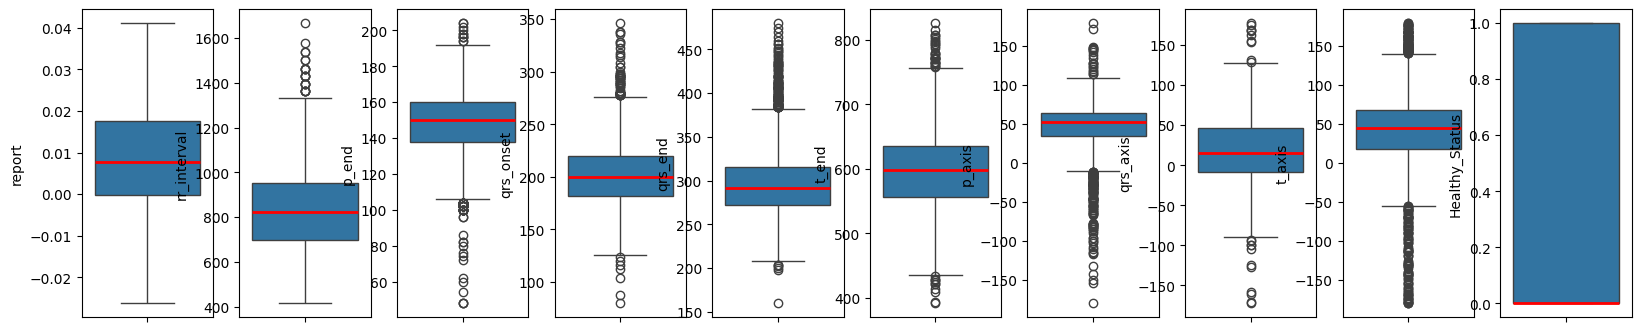

In [17]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})

In [18]:
# удаляем аномалии из данных (убрать все значения более 5000)
#table_data = table_data.drop(table_data[table_data['qrs_axis'] > 5000].index)
for i, v in enumerate(table_data):
  table_data = table_data.drop(table_data[table_data.iloc[:,i] > 10000].index)

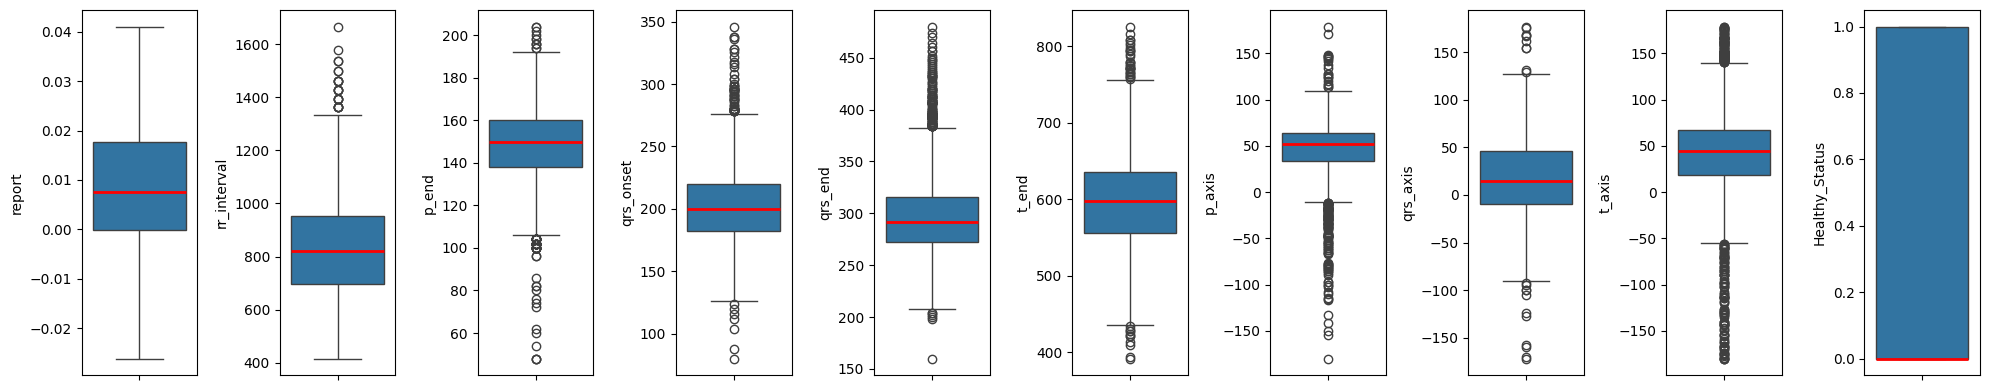

In [25]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data,
                medianprops={"color": "r", "linewidth": 2})

plt.tight_layout()
#plt.show()

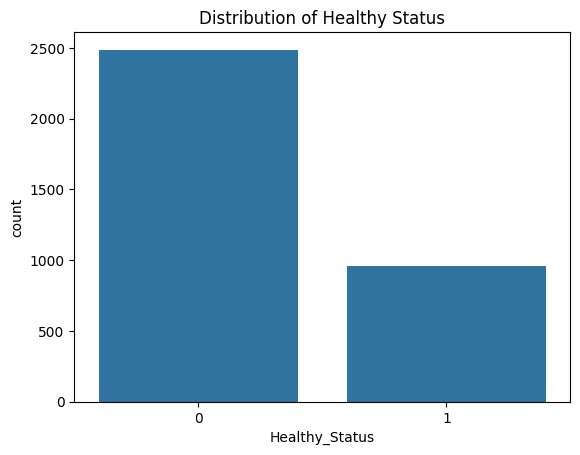

In [26]:
sns.countplot(data=table_data, x="Healthy_Status")
plt.title("Distribution of Healthy Status")
plt.show()

## Visualization examplpes

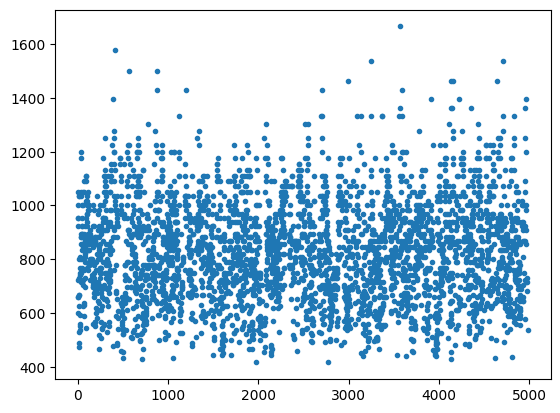

In [27]:
#example view
plt.plot(table_data['rr_interval'],'.')

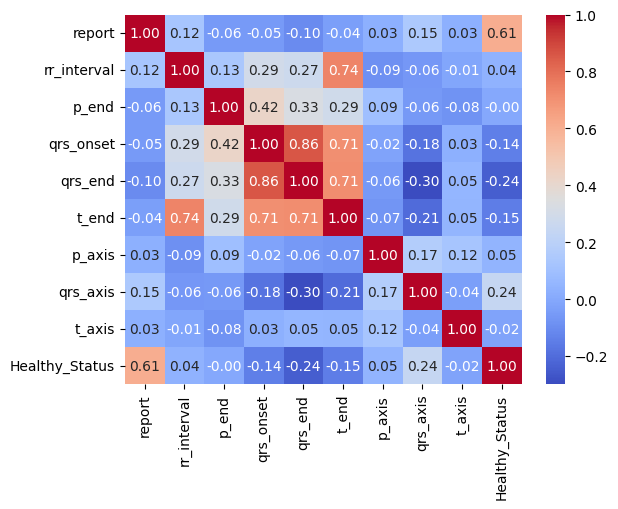

In [28]:
sns.heatmap(table_data.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()

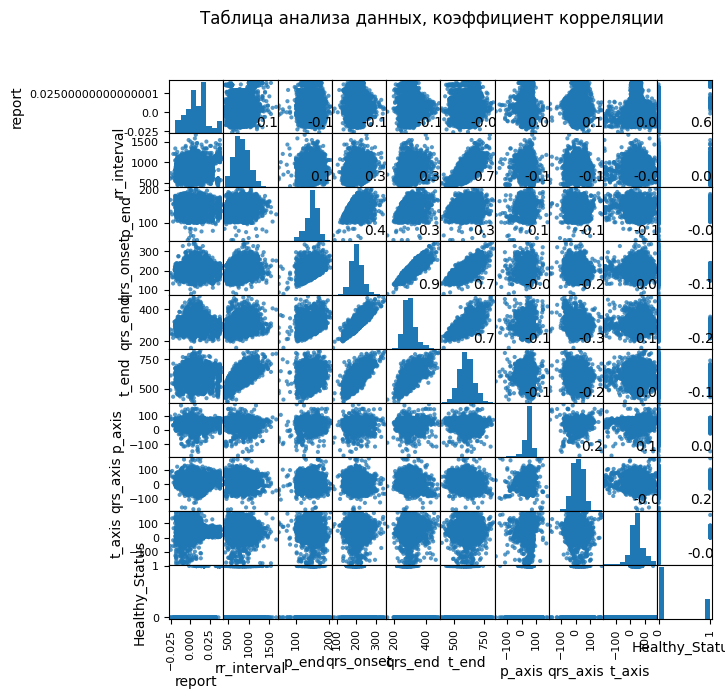

In [29]:
plotScatterMatrix(table_data, 7, 10)

<Axes: xlabel='rr_interval', ylabel='p_axis'>

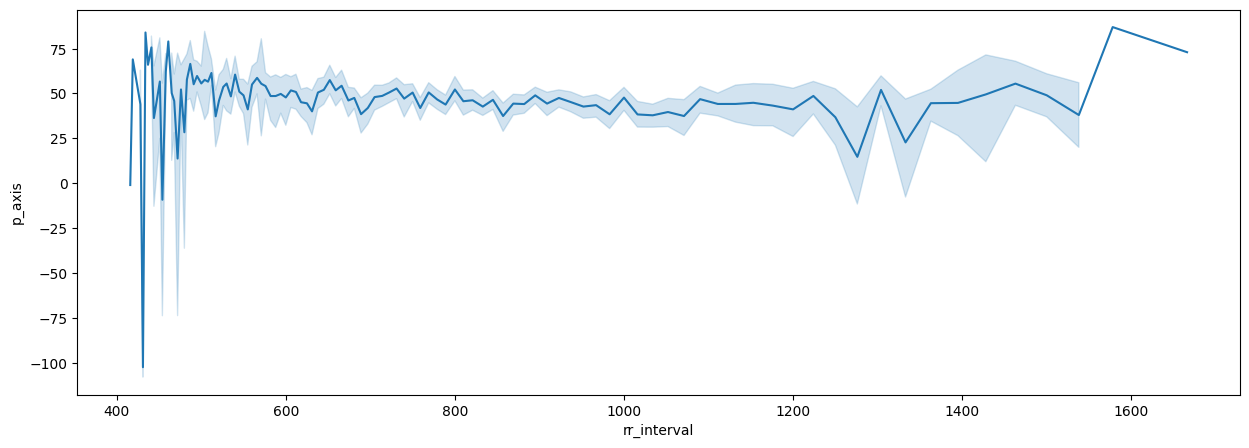

In [30]:
fig,ax = plt.subplots(figsize=(15,5))
#sns.lineplot(x='age',y='debtinc',data=table_data,ax=ax)
sns.lineplot(x='rr_interval',y='p_axis',data=table_data,ax=ax)

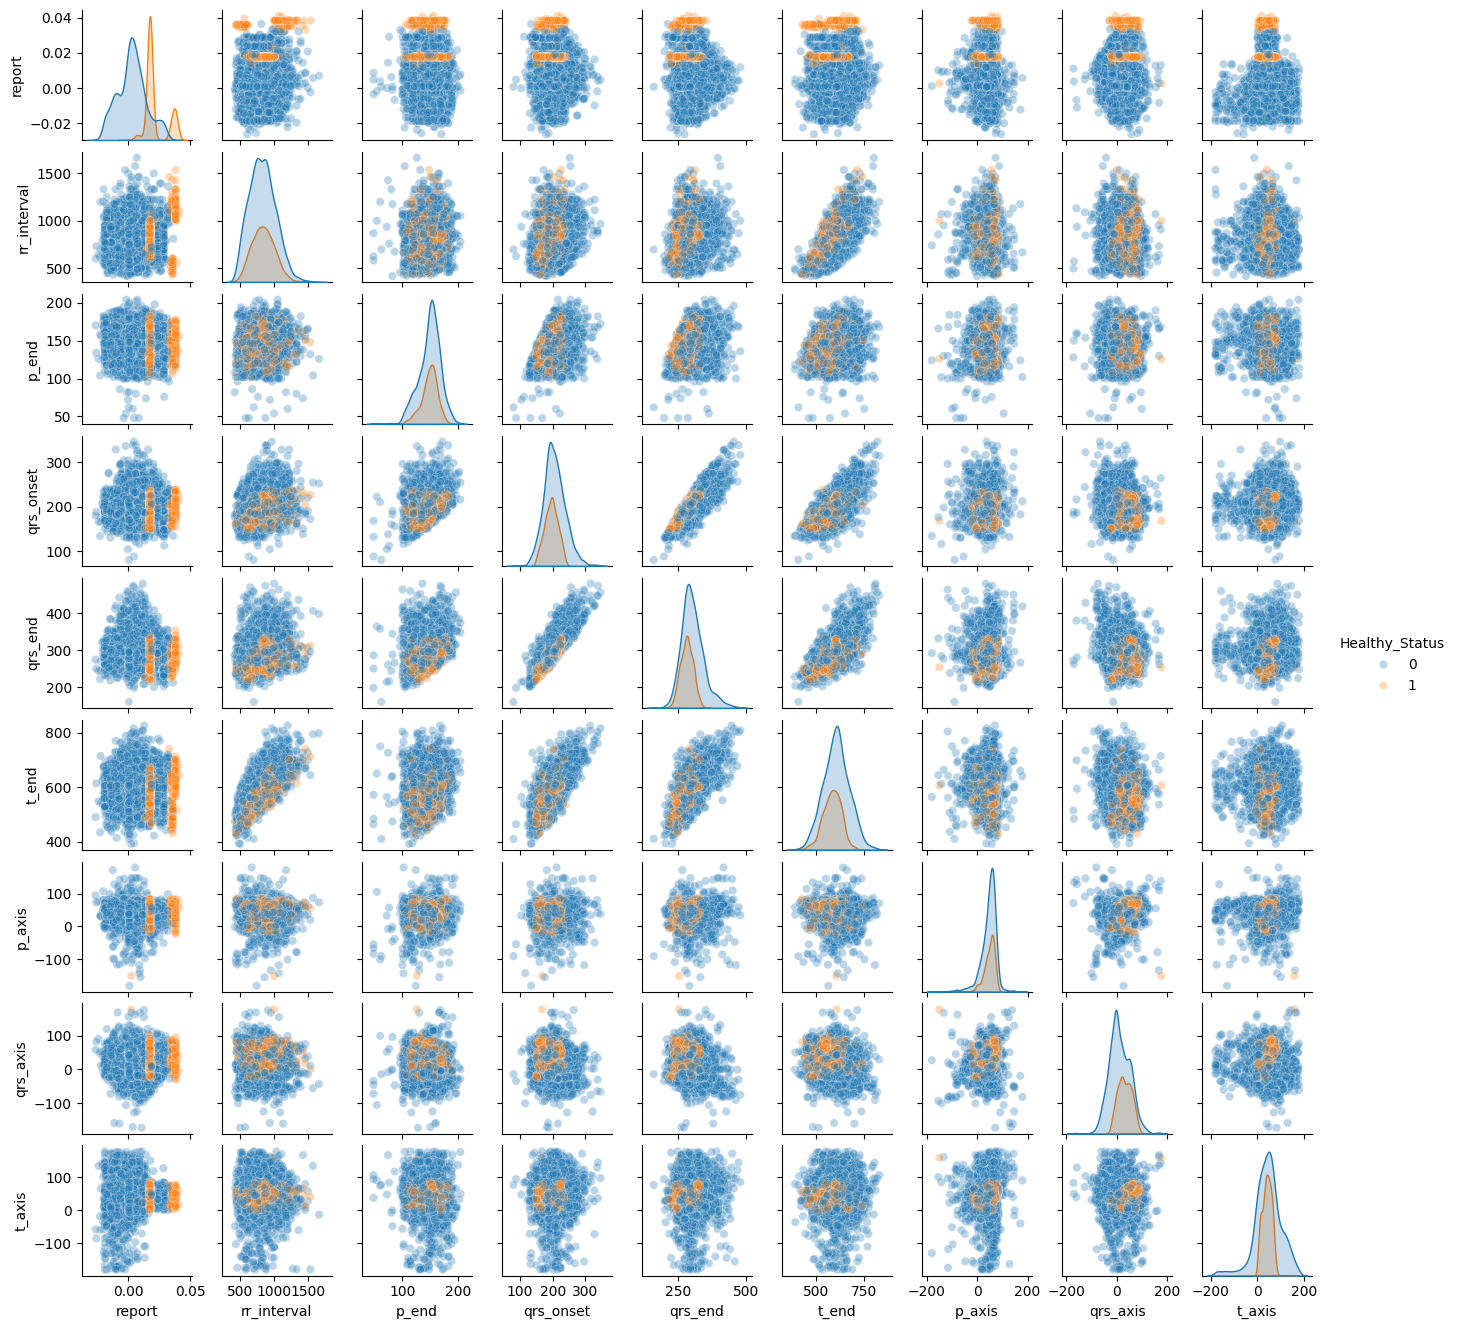

In [31]:
#labels = pd.DataFrame(table_data['Healthy_Status'])
sns.pairplot(table_data, hue = "Healthy_Status",
             height=1.5,
             plot_kws=dict(alpha=0.3))

<Axes: xlabel='rr_interval', ylabel='qrs_end'>

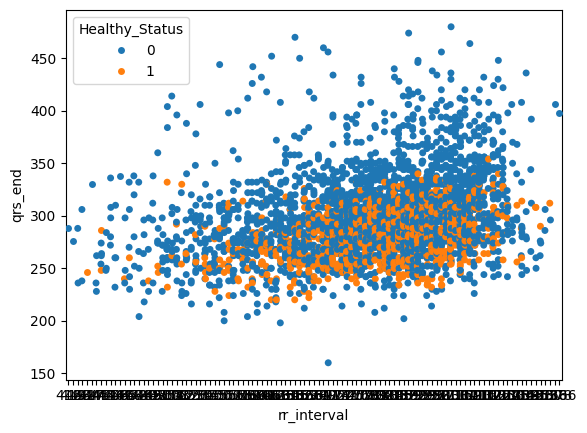

In [32]:
sns.stripplot(x=table_data['rr_interval'],y=table_data['qrs_end'],
              hue=table_data['Healthy_Status'],jitter=True)

<Axes: xlabel='rr_interval'>

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 58.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


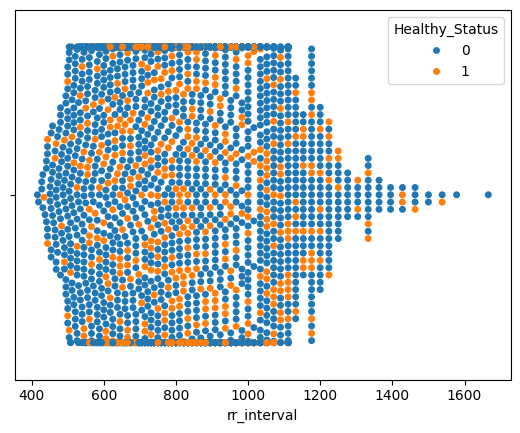

In [33]:
sns.swarmplot(data=table_data, x="rr_interval", hue="Healthy_Status")

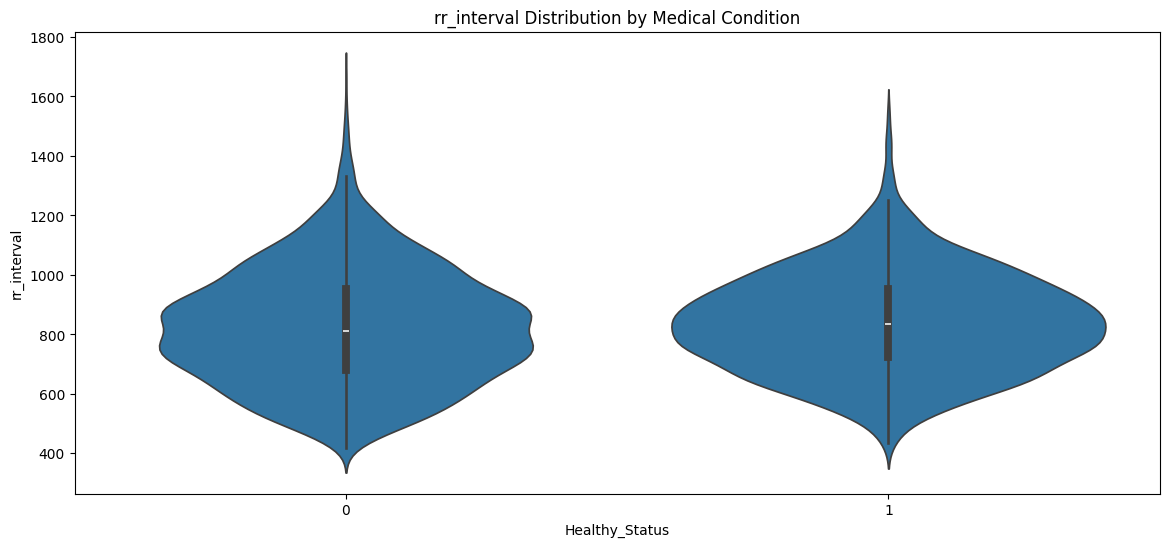

In [34]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=table_data, y='rr_interval', x='Healthy_Status')
plt.title('rr_interval Distribution by Medical Condition')
plt.show()

# Обработка данных: PCA, ICA, t-SNE

## PCA - principal component analysis

https://web.archive.org/web/20090528101113/http://www.chemometrics.ru/materials/textbooks/pca.htm

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [36]:
#table_data_pca = full_df_filtered
table_data_pca = table_data
table_data_pca = table_data_pca.drop('Healthy_Status', axis = 1)
table_data_pca.columns

Index(['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
       'p_axis', 'qrs_axis', 't_axis'],
      dtype='object')

In [37]:
#cancer = load_breast_cancer()
# Before applying PCA, each feature should be centered (zero mean) and with unit variance
scaled_data = StandardScaler().fit(table_data_pca).transform(table_data_pca)
pca = PCA(n_components = 2).fit(scaled_data)
# PCA(copy=True, n_components=2, whiten=False)
x_pca = pca.transform(scaled_data)
print(table_data.shape, x_pca.shape)

(3448, 10) (3448, 2)


In [38]:
percent = pca.explained_variance_ratio_
print(percent)
print(sum(percent))
#To see how much variance is preserved for each dataset.

[0.34439212 0.13781298]
0.4822050987229709


In [39]:
def pca_explained(X, threshold):
  features = X.shape[1]
  for i in range(2, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    # add all components explained variances
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if percent > threshold:
      break

pca_explained(scaled_data, 0.85)

2 components at 48.22% explained variance
3 components at 61.32% explained variance
4 components at 73.14% explained variance
5 components at 82.25% explained variance
6 components at 90.24% explained variance


Text(0, 0.5, 'Second Principal Component')

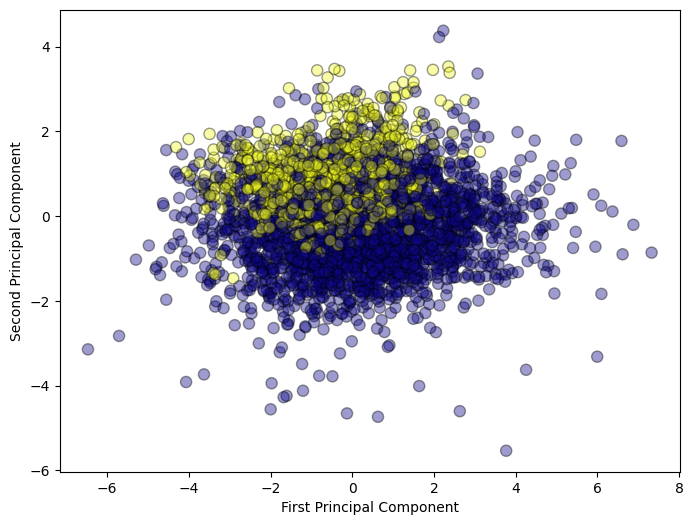

In [40]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

<ipython-input-43-efa34ae63df1>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.9, facecolor='white', head_width=.01)
<ipython-input-43-efa34ae63df1>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')


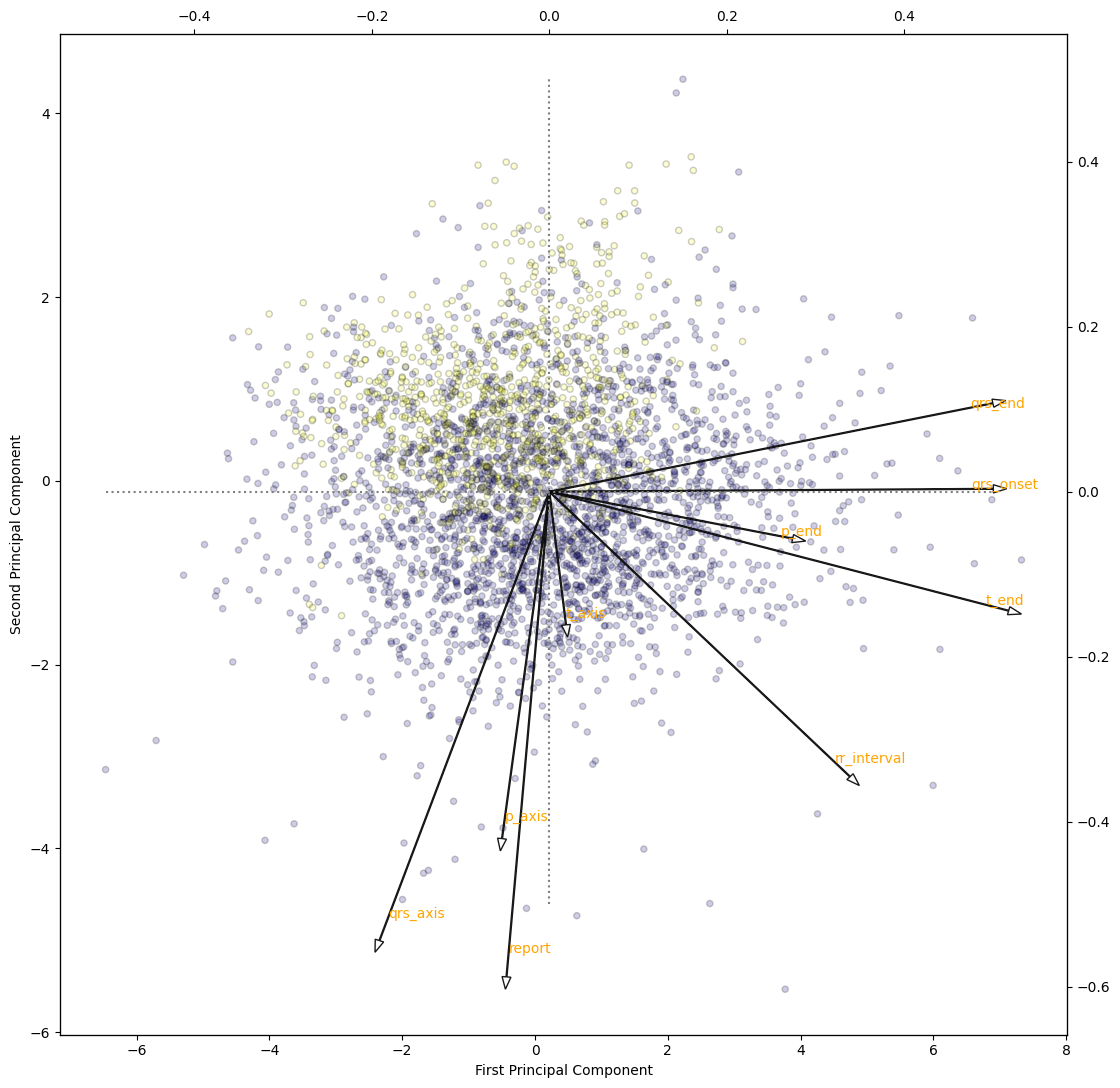

In [43]:
# put feature values into dataframe
components = pd.DataFrame(pca.components_.T, index=table_data_pca.columns, columns= ['PCA1','PCA2'])
# plot size
plt.figure(figsize=(13,13))
# main scatterplot
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'],
            cmap='plasma', alpha=0.2, edgecolors='black', s=20);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
#plt.ylim(15,-15);
#plt.xlim(20,-20);

# individual feature values
ax2 = plt.twinx().twiny();
#ax2.set_ylim(-0.5,0.5);
#ax2.set_xlim(-0.5,0.5);

# reference lines
ax2.hlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
ax2.vlines(0,-0.5,0.5, linestyles='dotted', colors='grey')

# offset for labels
offset = 0.95
# arrow & text
for a, i in enumerate(components.index):
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.9, facecolor='white', head_width=.01)
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')

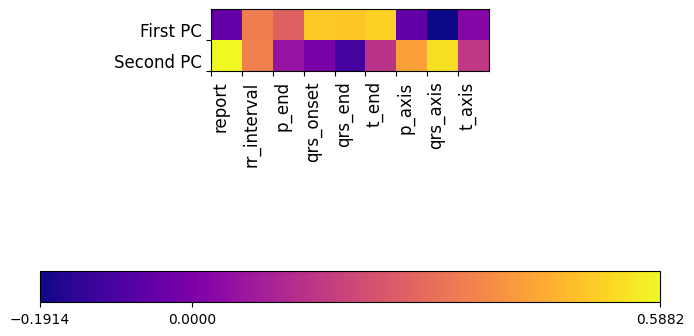

In [44]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(table_data_pca.columns)
plt.gca().set_xticks(np.arange(-.5, len(feature_names)-1));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left',fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom',fontsize=12);
plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()],pad=0.65);

## t-SNE stohastic neighbor embedings

Text(0, 0.5, 'Second Principal Component')

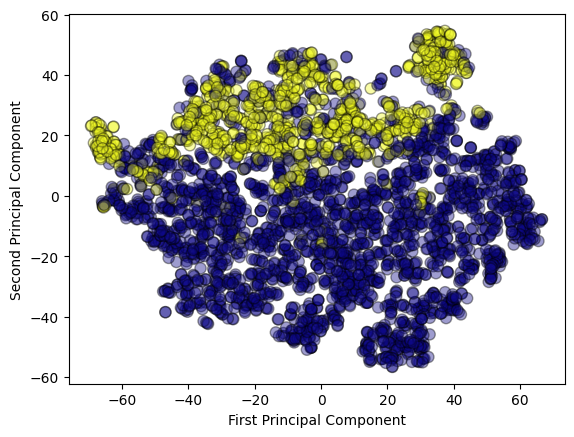

In [45]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
scaled_data_tsne = tsne.fit_transform(scaled_data)
plt.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [46]:
from sklearn import manifold
from time import time

Time code evaluation for perplexity=1 in 8.6 sec
Time code evaluation for perplexity=5 in 8.3 sec
Time code evaluation for perplexity=10 in 9.8 sec
Time code evaluation for perplexity=15 in 11 sec
Time code evaluation for perplexity=20 in 12 sec
Time code evaluation for perplexity=30 in 12 sec
Time code evaluation for perplexity=40 in 11 sec
Time code evaluation for perplexity=50 in 11 sec
Time code evaluation for perplexity=100 in 14 sec


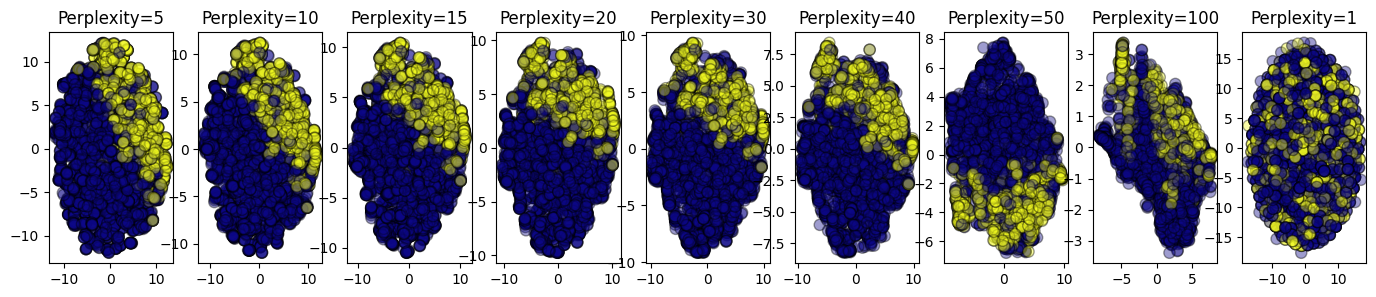

In [54]:
n_components = 2
perplexities = [1, 5, 10, 15, 20, 30, 40, 50, 100]
#perplexities = [5, 10]

(fig, subplots) = plt.subplots(1, len(perplexities), figsize=(17, 3))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i-1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        max_iter=300,
        )

    scaled_data_tsne = tsne.fit_transform(scaled_data)
    t1 = time()

    print("Time code evaluation for perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1],
               c=full_df_filtered['Healthy_Status'],
               cmap='plasma',
               alpha=0.4,
               edgecolors='black',
               s=65
               );
    ax.axis("tight")


## ICA independed component analysis

In [47]:
from sklearn.decomposition import FastICA

In [48]:
#Creating input data numpy array
#X = scaled_data.values

######################################################################
# Creating ICA object
ICA = FastICA(n_components=2)
scaled_data_ica = ICA.fit_transform(scaled_data)

Text(0, 0.5, 'Second Independed Component')

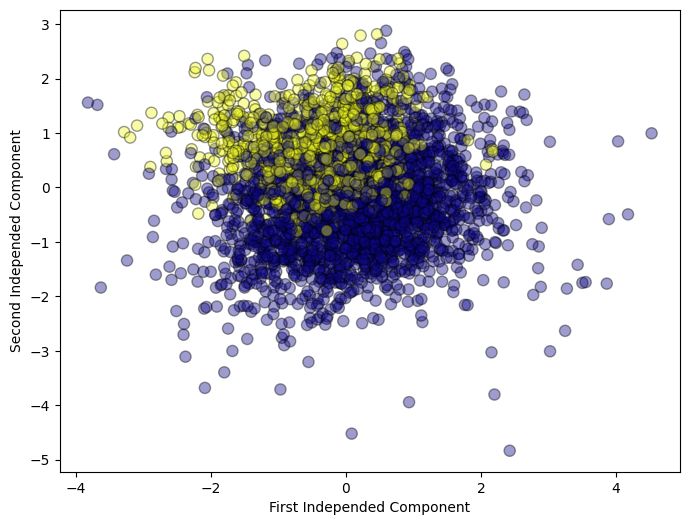

In [49]:
plt.figure(figsize=(8,6))
plt.scatter(scaled_data_ica[:,0],
            scaled_data_ica[:,1],
            c=full_df_filtered['Healthy_Status'],
            cmap='plasma',
            alpha=0.4,
            edgecolors='black',
            s=65
            );
plt.xlabel('First Independed Component')
plt.ylabel('Second Independed Component')

# ML методы

## ML: GussianClassifier + описание классов и матрица ошибок

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
table_data.columns

In [ ]:
# set the classification index of table
clf_index = 9

In [ ]:
plt.figure(figsize=(35,20),dpi=90)
# Plot frequency percentages barplot
table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

In [ ]:
# classification variable
y1 = table_data.iloc[:, clf_index]
# input variable
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]

y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values,
                                                        y1.values,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y1.values)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X1.values,
                                                 y1.values,
                                                 test_size=0.3,
                                                 random_state=41,
                                                 stratify=y1.values)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
GussianClassifier = GaussianNB()
GussianClassifier.fit(X1_train,y1_train)
y_pred=GussianClassifier.predict(X_test)
print("===================================> Result <===================================")
print("Accuracy                     = " ,metrics.accuracy_score(y_test,y_pred))
print("F1 Score                     = " ,metrics.f1_score(y_test,y_pred))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_pred,labels=labels_names, target_names=target_names))
#cm = confusion_matrix(y_test, y_pred,labels=labels_names,normalize='true')
cm = confusion_matrix(y_test, y_pred,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [ ]:
cm = confusion_matrix(y_test,GussianClassifier.predict(X_test))

fig , ax  = plt.subplots(figsize=(4,4))
ax.imshow(cm, cmap = 'plasma')
ax.grid(False)
ax.xaxis.set(ticks=(0,1),ticklabels=("Predicted as True","Predicted as False"))
ax.yaxis.set(ticks=(0,1),ticklabels=("Actual as True","Actual as False"))
ax.set_ylim(1.5,-0.5)
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm[i,j],ha="center",va="center",color = "red")

# AutoML examples

In [11]:
# Убираем из датасета лишние столбцы
# Формируем датасет для AutoML методов
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()


## AutoML H2O

In [51]:
!pip install h2o --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 5.3 MB/s eta 0:00:00


In [52]:
import h2o
from h2o.frame import H2OFrame
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score

In [53]:
# Инициализируем H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpydw9r4e_
  JVM stdout: /tmp/tmpydw9r4e_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpydw9r4e_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         06 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    26 days
H2O_cluster_name:           H2O_from_python_unknownUser_2eqhnp
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.11.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [54]:
# Переводим датафрейм в формат H2OFrame
h2o_df = H2OFrame(autoML_df)

# Разбиение на обучающую и тестовую выборки
random_seed = 17
train, test = h2o_df.split_frame(ratios=[0.85], seed=random_seed)

# Определяем целевую переменную и предикторы
y="Healthy_Status"
x = list(h2o_df.columns)
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [55]:
# Создаем и обучаем модель H2O AutoML
automl = H2OAutoML(max_runtime_secs=60, seed=random_seed, verbosity="info")
#automl= H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0)


automl.train(x=x, y=y, training_frame=train)

# Оценка модели на тестовом наборе
performance = automl.leader.model_performance(test_data=test)
print(performance)

AutoML progress: |
09:39:29.45: Project: AutoML_1_20250423_93928
09:39:29.48: 5-fold cross-validation will be used.
09:39:29.48: Setting stopping tolerance adaptively based on the training frame: 0.018464772811525407
09:39:29.48: Build control seed: 17
09:39:29.50: training frame: Frame key: AutoML_1_20250423_93928_training_py_2_sid_b581    cols: 10    rows: 2933  chunks: 1    size: 68508  checksum: 852019139087170701
09:39:29.50: validation frame: NULL
09:39:29.50: leaderboard frame: NULL
09:39:29.50: blending frame: NULL
09:39:29.50: response column: Healthy_Status
09:39:29.51: fold column: null
09:39:29.51: weights column: null
09:39:29.99: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (6g, 10w)]}, {DeepLearnin

In [56]:
lb = automl.leaderboard
lb.head()

model_id                                                    rmse        mse        mae      rmsle    mean_residual_deviance
------------------------------------------------------  --------  ---------  ---------  ---------  ------------------------
StackedEnsemble_AllModels_2_AutoML_1_20250423_93928     0.112266  0.0126037  0.0424392  0.0802701                 0.0126037
StackedEnsemble_BestOfFamily_3_AutoML_1_20250423_93928  0.113048  0.0127798  0.043956   0.0810027                 0.0127798
GBM_2_AutoML_1_20250423_93928                           0.11358   0.0129005  0.0436093  0.0817853                 0.0129005
StackedEnsemble_AllModels_1_AutoML_1_20250423_93928     0.113583  0.012901   0.043312   0.0816569                 0.012901
StackedEnsemble_BestOfFamily_2_AutoML_1_20250423_93928  0.113617  0.0129087  0.0437696  0.0818001                 0.0129087
GBM_3_AutoML_1_20250423_93928                           0.116142  0.0134889  0.0414421  0.0831866                 0.0134889
GBM_5_AutoML_1_20250423_93928                           0.120428  0.0145029  0.0581704  0.0861499                 0.0145029
GBM_4_AutoML_1_20250423_93928                           0.120434  0.0145044  0.0538489  0.0880019                 0.0145044
StackedEnsemble_BestOfFamily_1_AutoML_1_20250423_93928  0.127118  0.0161589  0.0590143  0.0911983                 0.0161589
XGBoost_1_AutoML_1_20250423_93928                       0.130988  0.0171578  0.0680802  0.0967248                 0.0171578
[10 rows x 6 columns]

In [57]:
model_ids = list(automl.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


['StackedEnsemble_AllModels_2_AutoML_1_20250423_93928',
 'StackedEnsemble_BestOfFamily_3_AutoML_1_20250423_93928',
 'GBM_2_AutoML_1_20250423_93928',
 'StackedEnsemble_AllModels_1_AutoML_1_20250423_93928',
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20250423_93928',
 'GBM_3_AutoML_1_20250423_93928',
 'GBM_5_AutoML_1_20250423_93928',
 'GBM_4_AutoML_1_20250423_93928',
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20250423_93928',
 'XGBoost_1_AutoML_1_20250423_93928',
 'DRF_1_AutoML_1_20250423_93928',
 'GBM_1_AutoML_1_20250423_93928',
 'XGBoost_2_AutoML_1_20250423_93928',
 'XRT_1_AutoML_1_20250423_93928',
 'XGBoost_3_AutoML_1_20250423_93928',
 'XGBoost_grid_1_AutoML_1_20250423_93928_model_1',
 'DeepLearning_1_AutoML_1_20250423_93928',
 'GBM_grid_1_AutoML_1_20250423_93928_model_1',
 'GLM_1_AutoML_1_20250423_93928']

In [58]:
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'silent': True,
  'eta': 0.3,
  'colsample_bylevel': 0.8,
  'objective': 'reg:squarederror',
  'min_child_weight': 10.0,
  'nthread': 2,
  'seed': 17,
  'max_depth': 15,
  'colsample_bytree': 0.8,
  'lambda': 1.0,
  'gamma': 0.0,
  'alpha': 0.0,
  'booster': 'gbtree',
  'grow_policy': 'depthwise',
  'nround': 43,
  'subsample': 0.6,
  'max_delta_step': 0.0,
  'tree_method': 'exact'},
 43)

In [59]:
automl.leader.model_performance(test)

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.00780406083156014
RMSE: 0.08834059560338124
MAE: 0.03958563389713881
RMSLE: 0.06612563513807655
Mean Residual Deviance: 0.00780406083156014
R^2: 0.9575419069938351
Null degrees of freedom: 514
Residual degrees of freedom: 508
Null deviance: 95.56748634029051
Residual deviance: 4.019091328253472
AIC: -1021.8455073846937

In [60]:
test_predict = automl.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


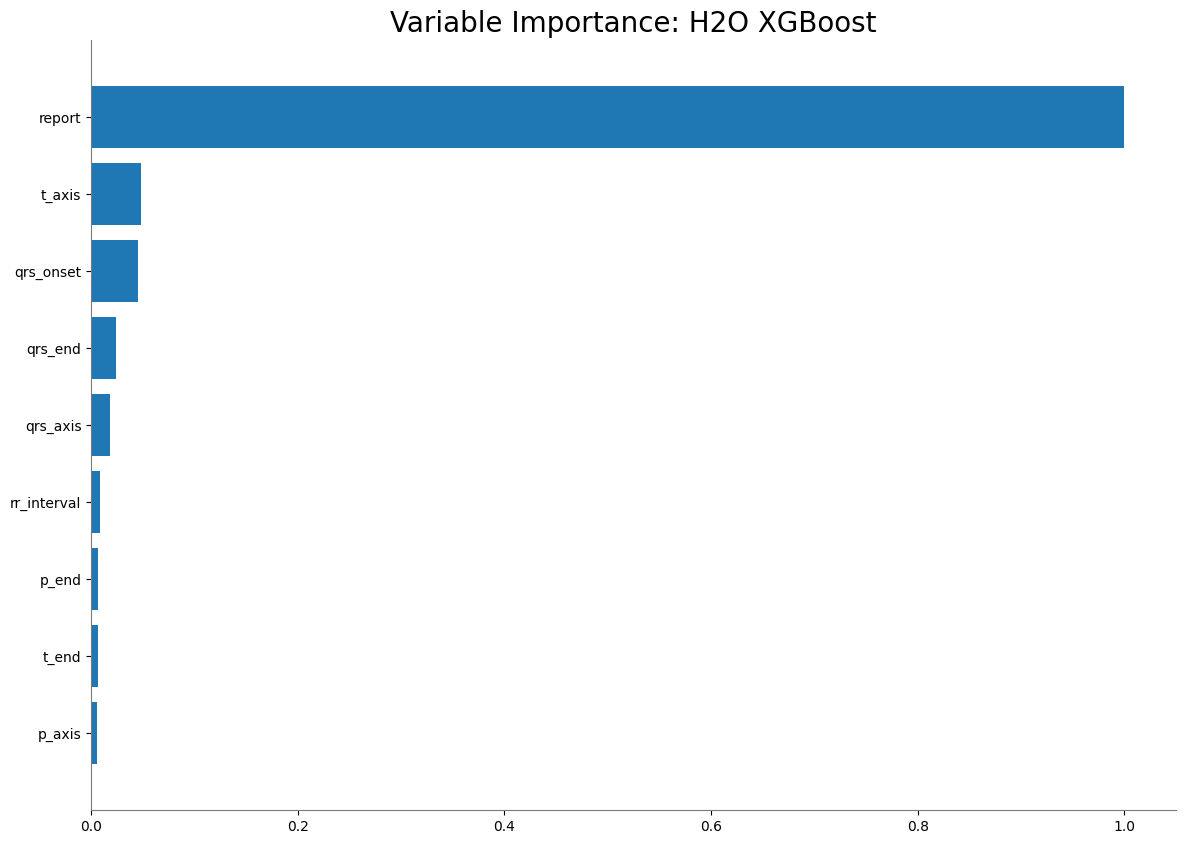

<Figure size 640x480 with 0 Axes>

In [61]:
out.varimp_plot()

In [62]:
# H2OFrame
test_preds = h2o.as_list(test_predict)
test_preds = test_preds['predict']

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [63]:
test_Y = h2o.as_list(test['Healthy_Status'])
test_Y = test_Y['Healthy_Status']

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [64]:
# Вычисляем F1-меру с помощью confusion matrix

# Порог отсечения - 0.5
for i in range(len(test_preds)):
  if test_preds[i] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0


cm = confusion_matrix(test_Y, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(test_Y, test_preds)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

Confusion matrix: [[388   2]
 [  2 123]]
F1-Score:  0.98
Accuracy: 0.99
Recall:  0.98
Precision:  0.98


In [65]:
# Завершение работы H2O
h2o.shutdown()

H2O session _sid_b581 closed.


<ipython-input-65-9ae954ad13ba>:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


## AutoML AutoGluon

In [ ]:
!pip install autogluon --quiet
!pip install autogluon.tabular[lightgbm] --quiet

In [ ]:
import autogluon

In [ ]:
# Импортируем необходимые библиотеки
from autogluon.tabular import TabularPredictor

In [ ]:
autoML_df.head()

In [ ]:
# Разбиение на обучающую и тестовую выборки
random_seed = 17

# set the classification index of table
clf_index = 9

target = 'Healthy_Status'

auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(
                                                        auto_X, auto_Y,
                                                        train_size=0.85,
                                                        random_state=random_seed,
                                                        stratify=auto_Y
                                                        )

# Создаем обучающий датафрейм
auto_train_df = auto_X_train.copy()
auto_test_df = auto_X_test.copy()
auto_train_df['Healthy_Status'] = auto_Y_train
auto_test_df['Healthy_Status'] = auto_Y_test

In [ ]:
# Создаем и обучаем модель
predictor = TabularPredictor(label='Healthy_Status', eval_metric='accuracy').fit(train_data=auto_train_df)

# Предсказание на тестовой выборке
y_pred = predictor.predict(auto_X_test)

In [ ]:
predictor.leaderboard(auto_test_df)

In [ ]:
!pip install autogluon.eda --quiet

In [ ]:
import autogluon.eda.auto as auto

In [ ]:
!pip install autogluon==1.2 --quiet

In [ ]:
# scikit-learn moves the check_pandas_support api,
# HAVE TO downgrade to scikit-learn <= 1.4.2 can solve the problem
!pip install scikit-learn==1.4.2

In [ ]:
auto.target_analysis(train_data=auto_train_df, label=target)

In [ ]:
auto.dataset_overview(train_data=auto_train_df,
                      test_data=auto_test_df,
                      label=target)

In [ ]:
predictor.quick_fit(auto_train_df, target_col=target, show_feature_importance_barplots=True)


## AutoML BlueCast

https://github.com/ThomasMeissnerDS/BlueCast.git

https://www.kaggle.com/code/thomasmeiner/ps3e24-bluecast-eda-automl-tracking

In [ ]:
!pip install bluecast --quiet

In [ ]:
import numpy as np
import pandas as pd
import re


from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig
from bluecast.preprocessing.custom import CustomPreprocessing
from bluecast.general_utils.general_utils import save_to_production, load_for_production

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

In [ ]:
# Убираем из датасета лишние столбцы
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

autoML_df = autoML_df.drop(columns='report')

# Разбиение на обучающую и тестовую выборки

random_seed = 13

# set the classification index of table
clf_index = autoML_df.shape[1]-1

auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(auto_X, auto_Y, train_size=0.85, random_state=random_seed, stratify=auto_Y)

# Склеиваем признаки и таргеты в один датафрейм (только для обучающей выборки)
auto_train_df = auto_X_train
auto_train_df['Healthy_Status'] = auto_Y_train

# Создаем и обучаем модель
#automl = BlueCast(class_problem="binary")
#automl.fit(auto_train_df, target_col="Healthy_Status")

In [ ]:
#  Пример загрузки данных
#table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)

#df = table_data

# Проверка формы набора данных
#print('исходный набор данных: ',df.shape)

# Инициализация начального числа для генераторов случайных чисел
seed = 13

target = 'Healthy_Status'

# Создание обучающего набора с помощью выборки pandas — видимый набор данных
train_dataset = autoML_df.sample(frac=.8, random_state=seed)
#knowledge.reset_index(inplace=True, drop=True)
print('выделяем из исходного набора данныз базу для обучения: ', train_dataset.shape)

# Использование образцов, недоступных в обучающем наборе, в качестве будущего или невидимого набора данных
test_dataset = autoML_df.drop(train_dataset.index)
#payload.reset_index(inplace=True, drop=True)
print('набор данных для проверки: ',test_dataset.shape)


In [ ]:
# Предобрабатываем данные

full_df = df

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
#columns_to_filter = ['rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = full_df[(full_df[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

full_df_filtered.head()

In [ ]:
full_df_filtered['report']

In [ ]:
from bluecast.preprocessing.feature_types import FeatureTypeDetector

feat_type_detector = FeatureTypeDetector()
train_data = feat_type_detector.fit_transform_feature_types(train_dataset)

len(feat_type_detector.num_columns)

In [ ]:
#Automatic feature type detection from BlueCast
print(feat_type_detector.date_columns)

In [ ]:
feat_type_detector.num_columns

In [ ]:
feat_type_detector.cat_columns

In [ ]:
from bluecast.eda.analyse import (
    bi_variate_plots,
    correlation_heatmap,
    correlation_to_target,
    plot_pca,
    plot_theil_u_heatmap,
    plot_tsne,
    univariate_plots,
    check_unique_values,
    plot_null_percentage
)

In [ ]:
bi_variate_plots(
        full_df_filtered.loc[
            :, feat_type_detector.num_columns
        ],
        target,
    )

In [ ]:
# show correlation to target
correlation_to_target(
    full_df_filtered.loc[:, feat_type_detector.num_columns],
      target,
      )

In [ ]:
#no_correlation = ["p_axis", "p_end", "t_axis"]

no_correlation = ["p_onset", "subject_id", "p_end", "cart_id", "Count_subj"]

train = full_df_filtered.drop(no_correlation, axis=1)
test = full_df_filtered.drop(no_correlation, axis=1)

In [ ]:
correlation_heatmap(train_data.loc[
            :, train_data.columns.values])

In [ ]:
correlation_heatmap(train_data.loc[
            :, feat_type_detector.num_columns])

In [ ]:
# show feature space after principal component analysis
plot_pca(autoML_df.loc[
            :, feat_type_detector.num_columns
        ].fillna(0), target)

In [ ]:
# show feature space after t-SNE
plot_tsne(autoML_df.loc[
            :, feat_type_detector.num_columns
        ].sample(500, random_state=42).fillna(0), target, perplexity=30, random_state=0)

In [ ]:
from bluecast.eda.data_leakage_checks import (
    detect_categorical_leakage,
    detect_leakage_via_correlation,
)

In [ ]:
# Detect leakage of numeric columns based on correlation
numresult = detect_leakage_via_correlation(
        train_data.loc[:, feat_type_detector.num_columns].fillna(0), target, threshold=0.9 # target column is part of detected numerical columns here
    )

In [ ]:
# Detect leakage of categorical columns based on Theil's U
result = detect_categorical_leakage(
        train_data.loc[:, feat_type_detector.cat_columns + [target]], target, threshold=0.9
    )

In [ ]:
automl = BlueCast(class_problem="binary")

automl.conf_training.hyperparameter_tuning_rounds = 10
automl.conf_training.calculate_shap_values = False
automl.conf_training.use_full_data_for_final_model = False

In [ ]:
automl.fit_eval(
    df=autoML_df,
    df_eval=autoML_df.drop('Healthy_Status', axis=1),
    target_eval=autoML_df['Healthy_Status'],
    target_col="Healthy_Status",
)

In [ ]:
y_probs, test_preds = automl.predict(auto_X_test)

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(auto_Y_test, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(auto_Y_test, test_preds)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

## AutoML Fedot

In [66]:
!pip install -q scikit-learn==1.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 96.2 MB/s eta 0:00:00


In [67]:
!pip install -q --user scipy>=1.2.0

In [68]:
!pip install fedot --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.2/416.2 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.2/296.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.0/394.0 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [69]:
from fedot.api.main import Fedot
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

ImportError: cannot import name '_is_pandas_na' from 'sklearn.utils' (/usr/local/lib/python3.11/dist-packages/sklearn/utils/__init__.py)

In [ ]:
# Убираем из датасета лишние столбцы
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

autoML_df = autoML_df.drop(columns='report')

# Разбиение на обучающую и тестовую выборки

random_seed = 13

# set the classification index of table
clf_index = autoML_df.shape[1]-1

auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(auto_X, auto_Y, train_size=0.85, random_state=random_seed, stratify=auto_Y)

# Склеиваем признаки и таргеты в один датафрейм (только для обучающей выборки)
auto_train_df = auto_X_train
auto_train_df['Healthy_Status'] = auto_Y_train

# Создаем и обучаем модель
#automl = BlueCast(class_problem="binary")
#automl.fit(auto_train_df, target_col="Healthy_Status")

In [ ]:


#from data.data import get_train_data, get_test_data

#train_features, train_target = get_train_data()
#test_features, test_target = get_test_data()

# Task selection, initialisation of the framework
fedot_model = Fedot(problem='classification', timeout=3)

# Fit model
obtained_pipeline = fedot_model.fit(features=auto_X, target=auto_Y)
obtained_pipeline.show()


In [ ]:

# Make predictions
predict = fedot_model.predict(auto_X_test)
predict_probs = fedot_model.predict_proba(auto_X_test)

In [ ]:
plt.plot(predict_probs,'.')

In [ ]:
len(predict_probs)

In [ ]:
# Вычисляем F1-меру с помощью confusion matrix

# Порог отсечения - 0.5
for i in range(len(predict_probs)):
  if predict_probs[i] > 0.5:
    predict_probs[i] = 1
  else:
    predict_probs[i] = 0


cm = confusion_matrix(auto_Y_test, predict_probs)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(auto_Y_test, predict_probs)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

## AutoML LightAutoML

https://github.com/sb-ai-lab/LightAutoML


In [12]:
!pip install shap --quiet

%%time prints the wall time for the entire cell whereas
%time gives you the time for first line only

In [14]:
%%time
!pip install -U lightautoml --quiet

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 10.5 MB/s eta 0:00:00


In [15]:
# Импорт библиотек для auto ml
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import torch

import pandas as pd
import numpy as np

In [16]:
N_THREADS = 4 #number of vCPUs for LightAutoML model creation
N_FOLDS = 3 # number of folds in LightAutoML inner CV
#All models that are trained during the cross-validation loop
#on different folds are then saved for the inference phase.
#Inference on new data is made by averaging models from all train folds.

RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 100 # Time in seconds for automl run
TARGET_NAME = 'Healthy_Status' # Target column name

In [17]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [18]:
train_data, test_data = train_test_split(
    autoML_df,
    test_size=TEST_SIZE,
    stratify=autoML_df[TARGET_NAME],
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data is splitted. Parts sizes: train_data = (2758, 10), test_data = (690, 10)


report  rr_interval  p_end  qrs_onset  qrs_end  t_end  p_axis  \
1862  0.015036          983    144        198      300    604      28   
3660  0.022280          722    144        190      278    566      49   
498   0.022280          645    108        206      288    584      68   
4130  0.014933          576    160        184      266    502      64   
1092  0.022280          659    152        190      276    560      56   

      qrs_axis  t_axis  Healthy_Status  
1862        70      33               1  
3660        32      26               1  
498         64      60               1  
4130       -11      79               0  
1092        83      23               1

In [19]:
#The following task types are available:
#'binary' - for binary classification.
#'reg’ - for regression.
#‘multiclass’ - for multiclass classification.
#'multi:reg - for multiple regression.
#'multilabel' - for multi-label classification.

task = Task('binary')

You can also optionally specify the following roles:

'numeric' - numerical feature

'category' - categorical feature

'text' - text data

'datetime' - features with date and time

'date' - features with date only

'group' - features by which the data can be divided into groups and which can be taken into account for group k-fold validation (so the same group is not represented in both testing and training sets)

'drop' - features to drop, they will not be used in model building

'weights' - object weights for the loss and metric

'path' - image file paths (for CV tasks)

'treatment' - object group in uplift modelling tasks: treatment or control

In [20]:
roles = {
    'target': TARGET_NAME
    #'category': TARGET_NAME
    #'drop': ['name of column']
}

In [21]:
automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [22]:
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 0)

INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: binary

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 100.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 4 cores
INFO:lightautoml.automl.presets.base:- memory: 16 GB

INFO:lightautoml.reader.base:Train data shape: (2758, 10)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 90.01 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0], 'embed_sizes': array([11], dtype=int32), 'data_size': 11}
INFO2:lightautoml.ml_a

In [23]:
import matplotlib.pyplot as plt

In [24]:
test_predictions = automl.predict(test_data).data
#print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')
#plt.plot(test_predictions.data[:],'.')

In [25]:
test_data.head()

report  rr_interval  p_end  qrs_onset  qrs_end  t_end  p_axis  \
3795  0.000697          821    160        230      322    658      75   
2503  0.003116          923    150        220      316    620      17   
258   0.010578          895    140        194      272    584      59   
2411 -0.006945          845    104        210      382    676       2   
4894  0.018778          618    130        150      220    470      -5   

      qrs_axis  t_axis  Healthy_Status  
3795        84      76               0  
2503       -17      21               0  
258        -30      41               0  
2411       -63      97               0  
4894       -22      29               1

In [26]:
# Порог отсечения - 0.5
for i in range(len(test_predictions)):
  if test_predictions[i] > 0.5:
    test_predictions[i] = 1
  else:
    test_predictions[i] = 0

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(test_data['Healthy_Status'], test_predictions)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

Confusion matrix: [[495   3]
 [  8 184]]
F1-Score:  0.97
Accuracy: 0.98
Recall:  0.96
Precision:  0.98


In [27]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.84691 * (3 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.15309 * (3 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [28]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [29]:
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

[10:04:58] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[10:04:58] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[10:04:58] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[10:04:58] - time: 100.00 seconds


INFO:lightautoml.automl.presets.base:- time: 100.00 seconds


[10:04:58] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[10:04:58] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[10:04:58] Train data shape: (2758, 10)



INFO:lightautoml.reader.base:Train data shape: (2758, 10)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[10:04:59] Layer 1 train process start. Time left 99.84 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 99.84 secs


[10:04:59] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0], 'embed_sizes': array([11], dtype=int32), 'data_size': 11}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.9178040286144579
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.9221926769578314
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.9266989834337349
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.9422533885542168
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.9465420274849

[10:05:00] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9618901800670017


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9618901800670017


[10:05:00] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[10:05:00] Time left 97.92 secs



INFO:lightautoml.automl.base:Time left 97.92 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.989575
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.989776
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993414
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.993229
INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993329
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[345]	valid's auc: 0.993788


[10:05:01] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[10:05:01] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.993723
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.993988
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.994029
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.9948
INFO3:lightautoml.ml_algo.

[10:05:02] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9917864059882747


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9917864059882747


[10:05:02] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[10:05:02] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 16.70 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 16.70 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-c48355c0-156b-4add-b16e-78a38ccdbcb0
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.994482
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.994476
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.994447
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[110]	valid's auc: 0.994582
INFO:optuna.study.study:Trial 0 finished with value: 0.994581842996988 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda'

[10:05:19] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.5070789805579223, 'num_leaves': 127, 'bagging_fraction': 0.915632965139831, 'min_sum_hessian_in_leaf': 0.05040628974578082, 'reg_alpha': 1.6595963980295608e-05, 'reg_lambda': 8.989819719913048e-05}
 achieve 0.9957 auc


[10:05:19] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 127, 'feature_fraction': 0.5070789805579223, 'bagging_fraction': 0.915632965139831, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1.6595963980295608e-05, 'reg_lambda': 8.989819719913048e-05, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.05040628974578082}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.995076
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[54]	valid's auc: 

[10:05:20] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9972983406616415


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9972983406616415


[10:05:20] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[10:05:20] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9327260	best: 0.9327260 (0)	total: 1.53ms	remaining: 764ms
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9929405	best: 0.9929993 (96)	total: 219ms	remaining: 864ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting 

[10:05:22] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9956049780150754


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9956049780150754


[10:05:22] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[10:05:22] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 45.46 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 45.46 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-df5fa5f0-c8f1-4ce9-b2e4-ae1fdcfd664a
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9275961	best: 0.9275961 (0)	total: 6.73ms	remaining: 3.36s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9909521	best: 0.9911639 (99)	total: 299ms	remaining: 1.18s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9922051	best: 0.9923346 (184)	total: 496ms	remaining: 737ms
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9927405	best: 0.9927405 (300)	total: 764ms	remaining: 505ms
INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9927346	best: 0.9929170 (351)	total: 1.06s	remaining: 263ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9929

[10:06:09] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 4, 'l2_leaf_reg': 0.4767574538936398, 'min_data_in_leaf': 2}
 achieve 0.9938 auc


[10:06:09] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.4767574538936398, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 2, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9275961	best: 0.9275961 (0)	total: 5.85ms	remaining: 17.5s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9921463	best: 0.9928229 (55)	total: 388ms	remaining: 11.1s
INFO3:lightautoml.ml_algo.boost

[10:06:12] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9950475031407034


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9950475031407034


[10:06:12] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[10:06:12] Time left 26.26 secs



INFO:lightautoml.automl.base:Time left 26.26 secs



[10:06:12] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[10:06:12] Blending: optimization starts with equal weights. Score = 0.9949579


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.9949579


[10:06:12] Blending: iteration 0: score = 0.9973016, weights = [0.         0.         0.92885745 0.07114254 0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.9973016, weights = [0.         0.         0.92885745 0.07114254 0.        ]


[10:06:13] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[10:06:13] Blending: best score = 0.9973016, best weights = [0.         0.         0.92885745 0.07114254 0.        ]


INFO:lightautoml.automl.blend:Blending: best score = 0.9973016, best weights = [0.         0.         0.92885745 0.07114254 0.        ]


[10:06:13] Automl preset training completed in 74.19 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 74.19 seconds



[10:06:13] Model description:
Final prediction for new objects (level 0) = 
	 0.92886 * (3 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.07114 * (3 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.92886 * (3 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.07114 * (3 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 



In [30]:
!ls tabularAutoML_model_report

feature_importance.png		  valid_pr_curve.png
lama_interactive_report.html	  valid_preds_distribution_by_bins.png
valid_distribution_of_logits.png  valid_roc_curve.png
valid_pie_f1_metric.png


CPU times: user 85.3 ms, sys: 17.9 ms, total: 103 ms
Wall time: 97.6 ms


<Axes: xlabel='Feature'>

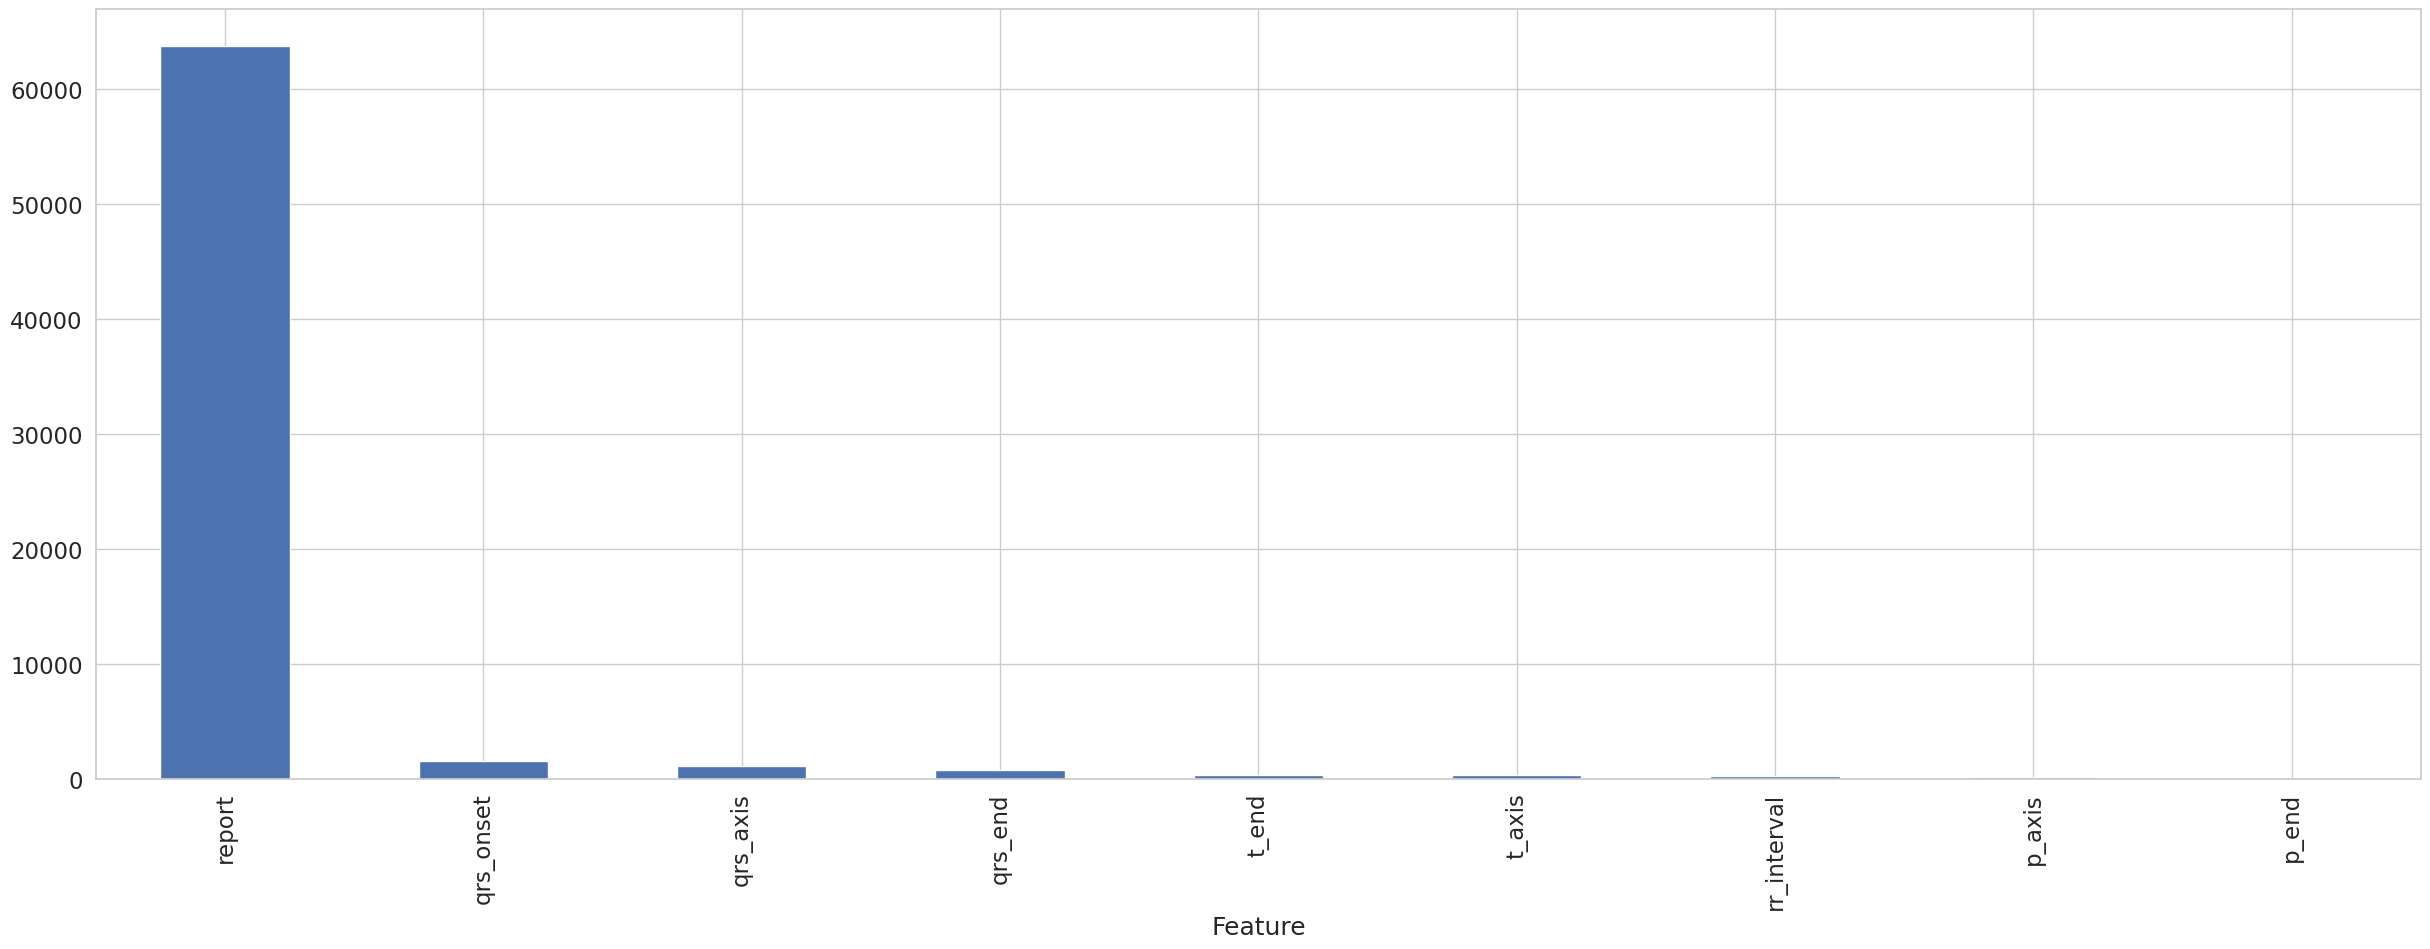

In [31]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

CPU times: user 2.04 s, sys: 454 ms, total: 2.5 s
Wall time: 1.92 s


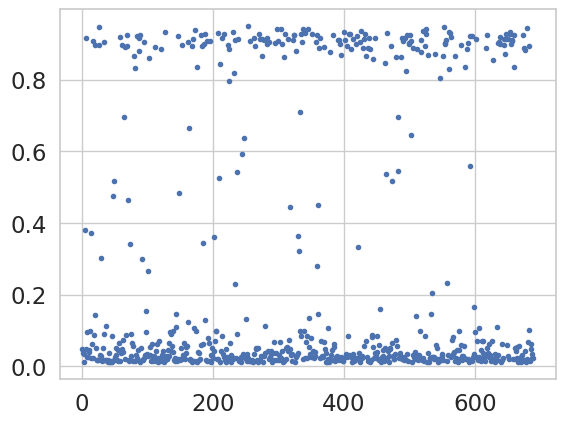

In [32]:
%%time
test_predictions = automl_rd.predict(test_data)
#print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')
plt.plot(test_predictions.data[:],'.')

In [33]:
#print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

HOLDOUT score: 0.9992574464524765


In [34]:
explainer = SSWARM(automl_rd.model)
shap_values = explainer.shap_values(test_data, n_jobs=N_THREADS)

100%|██████████| 1500/1500 [00:43<00:00, 34.83it/s]


<ipython-input-35-3501c991dd76>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[1], test_data[explainer.used_feats])


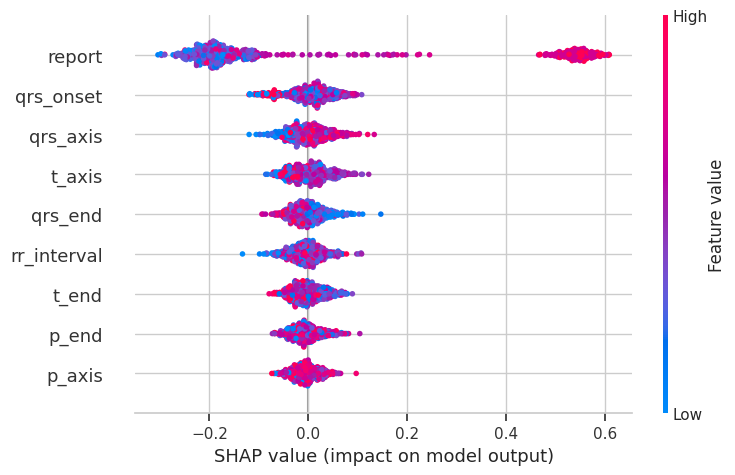

In [35]:
# summary plot
import shap
shap.summary_plot(shap_values[1], test_data[explainer.used_feats])

In [ ]:
train_data.head()

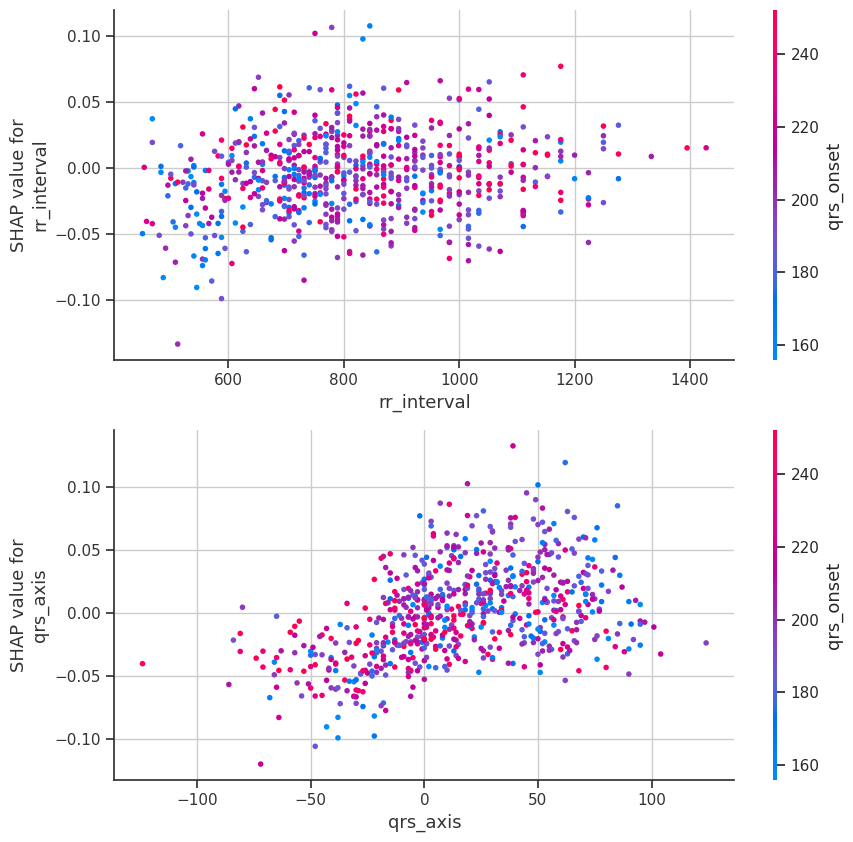

In [36]:
# dependence plots
import matplotlib.pyplot as plt

feats = ["rr_interval", "qrs_axis"]
fig, ax = plt.subplots(nrows=len(feats), ncols=1, figsize=(10, 5*len(feats)))

for i, feat in enumerate(feats):
    shap.dependence_plot(feat, shap_values[1], test_data[explainer.used_feats],
                         show=False, ax=ax[i], interaction_index="qrs_onset")

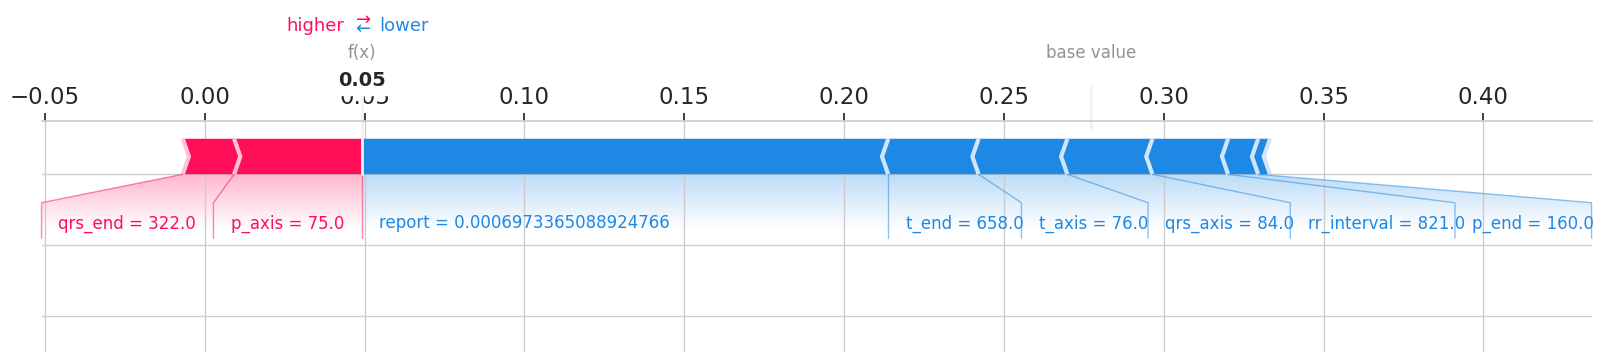

In [37]:
# individual force plot
shap.force_plot(explainer.expected_value[1], shap_values[1][0], test_data[explainer.used_feats].iloc[0], matplotlib=True)


## AutoML GAMA

https://openml-labs.github.io/gama/master/

In [ ]:
!pip install s

In [ ]:
!pip install gama --quiet

In [ ]:
from sklearn.metrics import log_loss, accuracy_score
from gama import GamaClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [ ]:
Y_auto = autoML_df['Healthy_Status'] # таргет
X_auto = autoML_df.iloc[:, :8] # переменные

# Разбиваем данные на обучающую и тестовую выборки
RANDOM_SEED = 0

X_train, X_test, y_train, y_test = train_test_split(X_auto, Y_auto, train_size=0.70, random_state=RANDOM_SEED, stratify=Y_auto)
print('Распределение Y_train по классам 0 и 1 соответственно:', np.bincount(y_train))
print('Распределение Y_test по классам 0 и 1 соответственно:', np.bincount(y_test))

In [ ]:
automl = GamaClassifier(max_total_time=60, store="nothing")
print("Starting `fit` which will take roughly 1 minutes.")
automl.fit(X_train, y_train)

In [ ]:
label_predictions = automl.predict(X_test)
probability_predictions = automl.predict_proba(X_test)

print('accuracy:', accuracy_score(y_test, label_predictions))
print('log loss:', log_loss(y_test, probability_predictions))
# the `score` function outputs the score on the metric optimized towards (by default, `log_loss`)
print('log_loss', automl.score(X_test, y_test))

In [ ]:
test_preds = label_predictions.data

# Порог отсечения - 0.5
for i in range(len(test_preds)):
  if test_preds[i] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(y_test, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

## AutoML PyCaret

https://habr.com/ru/companies/ods/articles/657525/

In [ ]:
!pip install pycaret --quiet

In [ ]:
#from pycaret.datasets import get_data

#  Набор данных о неплательщиках по кредиту
df = autoML_df

# Проверка формы набора данных
print('исходный набор данных: ',df.shape)

# Инициализация начального числа для генераторов случайных чисел
seed = 17

# Создание обучающего набора с помощью выборки pandas — видимый набор данных
train_data = df.sample(frac=.8, random_state=seed)
#knowledge.reset_index(inplace=True, drop=True)
print('выделяем из исходного набора данныз базу для обучения: ', train_data.shape)

# Использование образцов, недоступных в обучающем наборе, в качестве будущего или невидимого набора данных
test_data = df.drop(train_data.index)
#payload.reset_index(inplace=True, drop=True)
print('набор данных для проверки: ',test_data.shape)


In [ ]:
# Задействуем волшебную функцию!
from pycaret.classification import *

# Функция setup инициализирует среду и создает конвейер преобразования
clf = setup(data=autoML_df, target="Healthy_Status", session_id=123)

In [ ]:
# Сравниваем различные модели в зависимости от их метрик производительности. По умолчанию модели сортируются по точности
best_model = compare_models(fold=5)

# Построение кривой AUC
plot_model(best_model, plot="auc")

In [ ]:
# Функция Tune model выполняет сеточный поиск для определения оптимальных параметров
tuned = tune_model(best_model)
plot_model(tuned, plot="confusion_matrix")

# Прогнозирование на тестовом наборе
predict_model(tuned)

# Доработка модели путем переобучения на всем видимом наборе данных
final_model = finalize_model(tuned)

In [ ]:
# Прогнозирование на тестовом наборе
predict_model(tuned)

# Доработка модели путем переобучения на всем видимом наборе данных
final_model = finalize_model(tuned)

# Прогнозирование на невидимых данных
predictions = predict_model(final_model, data=test_data)
predictions.head()

# ML GaussianNaiveBayes

In [ ]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        classes, cls_counts = np.unique(y, return_counts=True)
        n_classes = len(classes)
        self.priors = cls_counts / len(y)

        # calculate the mean and standard deviations of features by classes
        self.X_cls_mean = np.array([np.mean(X[y == c], axis=0) for c in range(n_classes)])
        self.X_stds = np.array([np.std(X[y == c], axis=0) for c in range(n_classes)])

    # calculate the probability density of the feature according to the Gaussian distribution
    def pdf(self, x, mean, std):
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

    def predict(self, X):
        pdfs = np.array([self.pdf(x, self.X_cls_mean, self.X_stds) for x in X])
        posteriors = self.priors * np.prod(pdfs, axis=2)   # shorten Bayes formula

        return np.argmax(posteriors, axis=1)

In [ ]:
#So, when you do [:, -1] it means you are taking all the rows and only the last column. -1 represents the last column.
#When you do [:, :-1], it means you are taking all the rows and all the columns except the last column.
#X1, y1 = table_data.iloc[:, :-1], table_data.iloc[:, -1]

In [ ]:
# set the classification index of table
clf_index = 0

# classification variable
y1 = table_data.iloc[:, clf_index]
# input variable
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]

y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values,
                                                        y1.values,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y1.values)

In [ ]:
nb_clf = GaussianNaiveBayes()
nb_clf.fit(X1_train, y1_train)
nb_clf_pred_res = nb_clf.predict(X1_test)
nb_clf_accuracy = accuracy_score(y1_test, nb_clf_pred_res)

print(f'Naive Bayes classifier accucacy: {nb_clf_accuracy}')
print(nb_clf_pred_res)

In [ ]:
sk_nb_clf = GaussianNB()
sk_nb_clf.fit(X1_train, y1_train)
sk_nb_clf_pred_res = sk_nb_clf.predict(X1_test)
sk_nb_clf_accuracy = accuracy_score(y1_test, sk_nb_clf_pred_res)

print(f'sk Naive Bayes classifier accucacy: {sk_nb_clf_accuracy}')
print(sk_nb_clf_pred_res)

feature_indexes = [0, 6]
title1 = 'GaussianNB surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_nb_clf, feature_indexes, title1)

# MDS

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

In [ ]:
mds = MDS(n_components = 2)
scaled_data_mds = mds.fit_transform(scaled_data)

plt.scatter(scaled_data_mds[:,0], scaled_data_mds[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
scaled_data_mds_tsne = tsne.fit_transform(scaled_data)
plt.scatter(scaled_data_mds_tsne[:,0], scaled_data_mds_tsne[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster

In [ ]:

#scaled_data, data_table['Healthy_status'] = make_blobs(random_state = 10)
# n_clusters must be None if distance_threshold is not None
cls = AgglomerativeClustering(n_clusters = 5, affinity='euclidean',linkage='ward', distance_threshold=None)
cls_assignment = cls.fit_predict(scaled_data)

In [ ]:
Z = ward(scaled_data)
plt.figure(figsize=(17,5));
R = dendrogram(Z, truncate_mode='lastp', p=7, orientation='top', leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram (truncated and grouped)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

https://stackoverflow.com/questions/54810800/how-to-get-a-list-of-all-leaves-under-a-node-in-a-dendrogram

In [ ]:
# put X in a dataframe
df = pd.DataFrame()
df['col1']=X[:,0]
df['col2']=X[:,1]

index=[]
for i in range(len(X)):
    elem = 'A' + str(i)
    index.append(elem)

df['index'] = index
print(df.shape)
df.head()

# retrieve elements in each cluster
label = fcluster(Z, 5, criterion='maxclust')

df_clst = pd.DataFrame()
df_clst['index']  = df['index']
df_clst['label']  = label

# print them
for i in range(5):
   elements = df_clst[df_clst['label']==i+1]['index'].tolist()
   size = len(elements)
   print('\n Cluster {}: N = {}  {}'.format(i+1, size, elements))

In [ ]:
from scipy.cluster.hierarchy import fcluster
fl = fcluster(Z,5,criterion='maxclust')

In [ ]:
R

In [ ]:
R

In [ ]:
import scipy.cluster.hierarchy as sch

In [ ]:
linkage_matrix = sch.average(scaled_data)
rootnode, nodelist = sch.to_tree(linkage_matrix, rd=True)
leaves = sch.leaves_list(linkage_matrix)
print(linkage_matrix[3,:])
#sch.dendrogram(linkage_matrix);

In [ ]:
R

# Affinity propagation

In [ ]:
from sklearn import metrics
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import adjusted_rand_score

In [ ]:
def plot_connected_points(X, labels, centers, cmap):
    for i in range(len(X)):
        color = cmap(labels[i] / len(centers))
        plt.plot([X[i, 0], centers[labels[i], 0]], [X[i, 1], centers[labels[i], 1]], c=color, alpha=0.8)

In [ ]:
sk_ap = AffinityPropagation()
sk_ap_pred_res = sk_ap.fit_predict(scaled_data)
sk_ap_ari = adjusted_rand_score(table_data['Healthy_Status'], sk_ap_pred_res)
print(f'Adjusted Rand Score for sk AffinityPropagation: {sk_ap_ari}', '', sep='\n')
print('Number of clusters = ', np.max(sk_ap_pred_res))
#print('prediction', sk_ap_pred_res, sep='\n')

In [ ]:
plt.figure(figsize=(12, 5))

plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=sk_ap_pred_res, cmap='rainbow', s=10)
plt.scatter(sk_ap.cluster_centers_[:, 0], sk_ap.cluster_centers_[:, 1], c='black', s=50)
plt.title('AffinityPropagation (scikit-learn)')
plt.xlabel(table_data.columns[1])
plt.ylabel(table_data.columns[2])

plot_connected_points(scaled_data, sk_ap_pred_res, sk_ap.cluster_centers_, plt.cm.rainbow)

plt.show()

# Agglomerative Clustering

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    #plt.figure(figsize=(17,5));
    dendrogram(linkage_matrix, **kwargs)
    plt.rcParams["figure.figsize"] = (17,5)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()



In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(scaled_data)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
#

# Сравнение ML алгоритмов

In [ ]:
table_data.columns

In [ ]:
clf_index = 0
feature_indexes = [4, 7]

table_data_clf = (table_data.values[:,feature_indexes],
                  table_data[table_data.columns[clf_index]])

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


datasets = [
    #make_moons(noise=0.3, random_state=0),
    #make_circles(noise=0.2, factor=0.5, random_state=1),
    #linearly_separable,
    table_data_clf
]

figure = plt.figure(figsize=(27, 3))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    #x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    #y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    x_range = abs(X[:, 0].max()) - abs(X[:, 0].min())
    y_range = abs(X[:, 1].max()) - abs(X[:, 1].min())

    x_min, x_max = X[:, 0].min() - 0.05*x_range, X[:, 0].max() + 0.05*x_range
    y_min, y_max = X[:, 1].min() - 0.05*y_range, X[:, 1].max() + 0.05*y_range


    # just plot the dataset first
    cm = plt.cm.RdBu
    # red and blue = 0000FF color. Red = 0. Blue = 1 status
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    #ax.set_xticks(())
    #ax.set_yticks(())
    ax.set_xlabel(table_data.columns[feature_indexes[0]])
    ax.set_ylabel(table_data.columns[feature_indexes[1]])
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        #ax.scatter(
        #    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        #)
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="grey",
            alpha=0.4,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - x_range*0.1,
            y_min + y_range*0.1,
            ("%.2f" % score).lstrip("0"),
            size=25,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
datasets

# Примеры классификаторов на модельных задачах

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


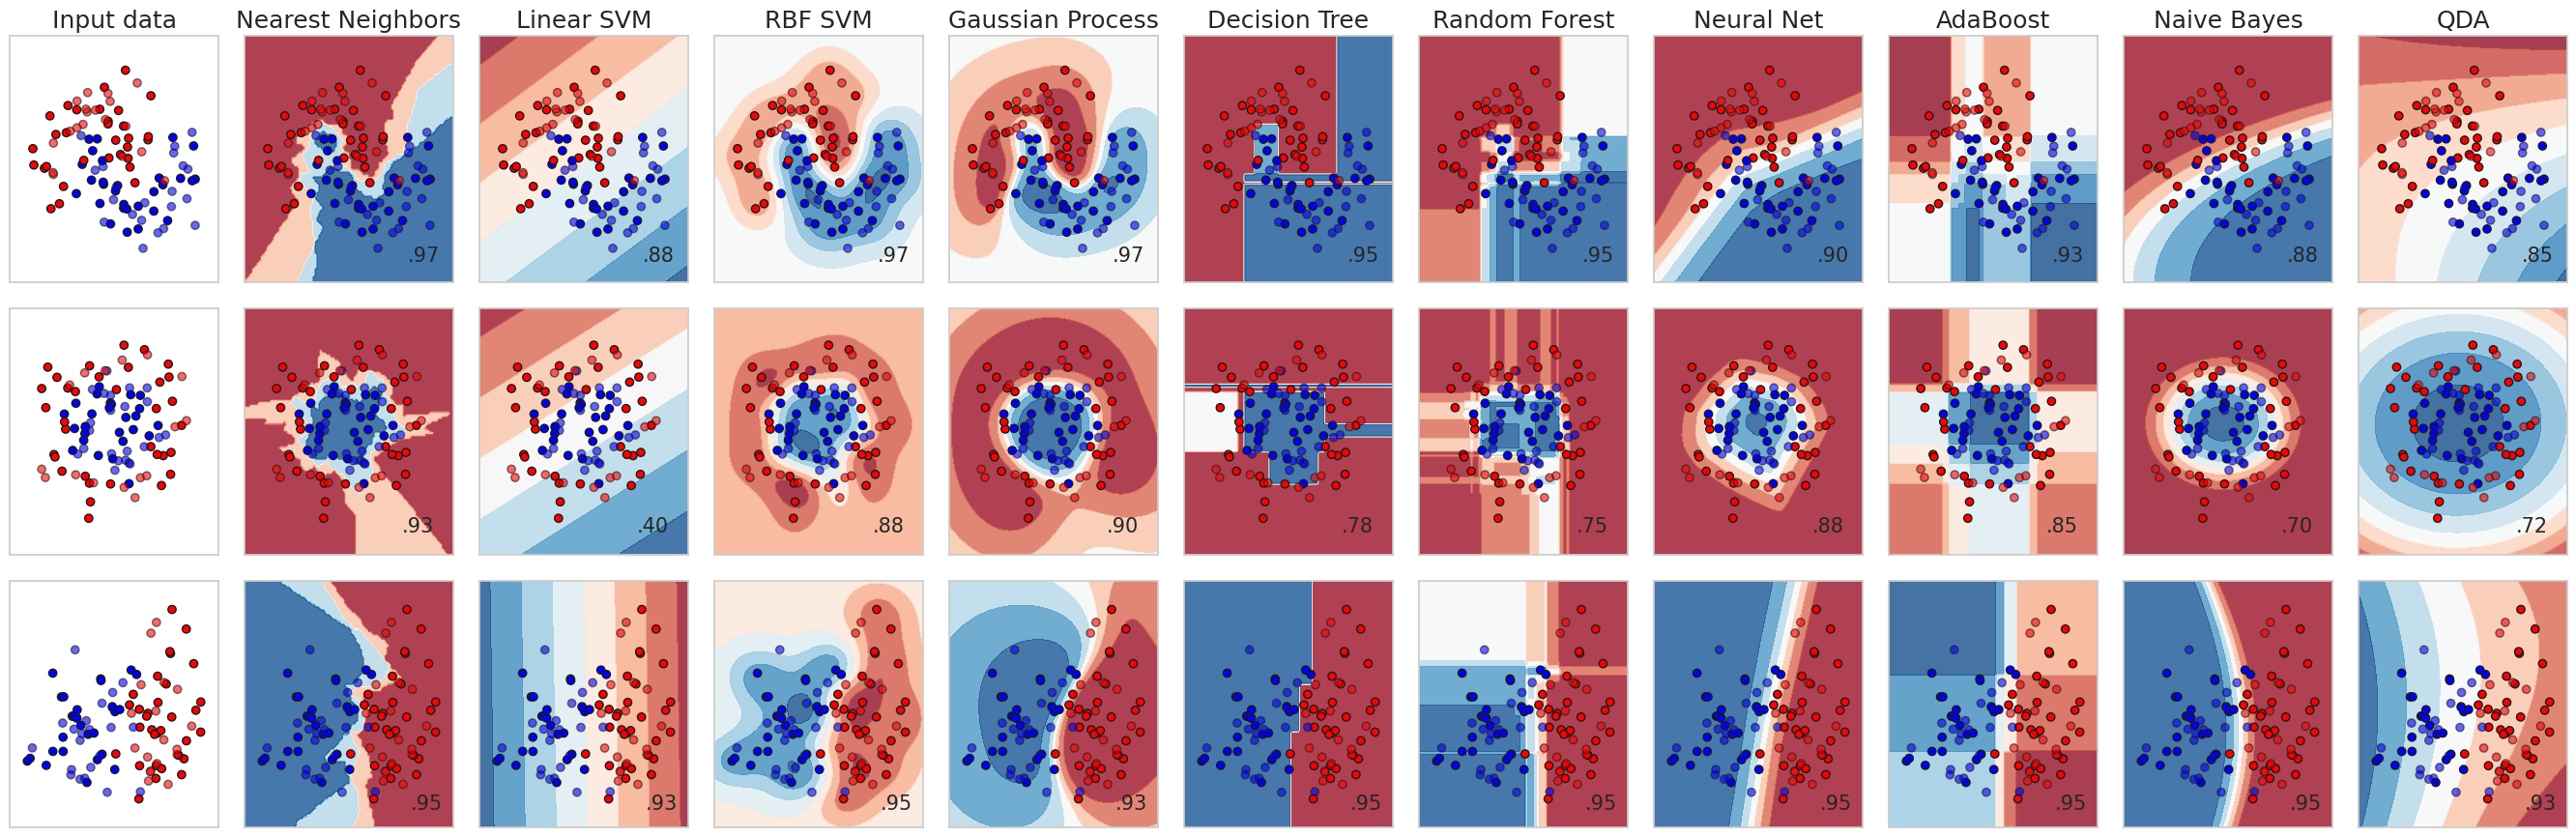

In [38]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    # red and blue = 0000FF color. Red = 0, Blue = 1 status
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()